In [1]:
#Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps

# Exploring the NFL Champion Data
-Using two datasets raw values and converting it to ranks (league rank data).

In [2]:
df = pd.read_excel("NFL Champion RawData.xlsx")
df.head(2)

,Season,Team ID,Team ID/Season,Team,Team/Season,over500 rec,over500 mov,7 point rec,sum mvp share,sum dpoy share,...,passing_offense_Y/G,passing_offense_Rate,passing_offense_Sk,passing_offense_Yds.1,passing_offense_Sk%,passing_offense_NY/A,passing_offense_ANY/A,passing_offense_4QC,passing_offense_GWD,passing_offense_EXP
0,2023,1,1 2022,Kansas City Chiefs,Kansas City Chiefs 2022,0.714286,2.588235,0.700000,0.86,0.0,...,297.8,104.7,26,188,3.8,7.5,7.9,4,4,232.54
1,2023,17,17 2022,Philadelphia Eagles,Philadelphia Eagles 2022,0.800000,5.294118,0.857143,0.00,0.0,...,241.5,99.0,44,259,7.6,7.1,7.2,1,2,131.17


In [3]:
df.columns

Index(['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season',
       'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share',
       'sum dpoy share',
       ...
       'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk',
       'passing_offense_Yds.1', 'passing_offense_Sk%', 'passing_offense_NY/A',
       'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD',
       'passing_offense_EXP'],
      dtype='object', length=120)

## Transform Raw Data File in NFL Champion LR Data
-transforms the datasets raw values entirely into ranks, except our main target champion share.

In [4]:
df = pd.read_excel("NFL Champion RawData.xlsx")

exclude_columns = ['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season',
                   'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share']

reverse_rank_columns = ['pso']

for col in df.columns:
    if col not in exclude_columns:
        if col in reverse_rank_columns:
            df[col] = df.groupby('Season')[col].rank(method='min', ascending=True)
        else:
            df[col] = df.groupby('Season')[col].rank(method='min', ascending=False)

df.to_csv("NFL Champion LR Data.csv", index=False)
print("NFL Champion LR Data.csv'")


NFL Champion LR Data.csv'


In [5]:
df = pd.read_csv("NFL Champion LR Data.csv")

In [6]:
#dropping data before 2000. Several features (sum) take past x years. 

df.drop(df[df['Season'] < 2000].index, inplace = True)
df

,Season,Team ID,Team ID/Season,Team,Team/Season,over500 rec,over500 mov,7 point rec,sum mvp share,sum dpoy share,...,passing_offense_Y/G,passing_offense_Rate,passing_offense_Sk,passing_offense_Yds.1,passing_offense_Sk%,passing_offense_NY/A,passing_offense_ANY/A,passing_offense_4QC,passing_offense_GWD,passing_offense_EXP
0,2023,1,1 2022,Kansas City Chiefs,Kansas City Chiefs 2022,3.0,5.0,4.0,4.0,16.0,...,1.0,1.0,30.0,27.0,31.0,1.0,1.0,3.0,6.0,1.0
1,2023,17,17 2022,Philadelphia Eagles,Philadelphia Eagles 2022,2.0,1.0,2.0,12.0,16.0,...,9.0,6.0,11.0,17.0,9.0,3.0,4.0,26.0,22.0,5.0
2,2023,19,19 2022,San Francisco 49ers,San Francisco 49ers 2022,1.0,3.0,5.0,12.0,16.0,...,13.0,2.0,27.0,25.0,22.0,3.0,2.0,17.0,22.0,3.0
3,2023,2,2 2022,Buffalo Bills,Buffalo Bills 2022,3.0,4.0,12.0,9.0,7.0,...,7.0,7.0,25.0,30.0,25.0,6.0,6.0,9.0,6.0,6.0
4,2023,18,18 2022,Minnesota Vikings,Minnesota Vikings 2022,6.0,21.0,1.0,12.0,14.0,...,6.0,12.0,8.0,7.0,17.0,13.0,12.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,2000,32,32 1999,Chicago Bears,Chicago Bears 1999,22.0,21.0,19.0,13.0,16.0,...,3.0,16.0,16.0,24.0,26.0,19.0,17.0,20.0,15.0,1.0
761,2000,17,17 1999,Philadelphia Eagles,Philadelphia Eagles 1999,19.0,24.0,23.0,13.0,24.0,...,31.0,29.0,6.0,7.0,3.0,31.0,30.0,12.0,6.0,1.0
762,2000,29,29 1999,Atlanta Falcons,Atlanta Falcons 1999,29.0,27.0,22.0,13.0,24.0,...,17.0,15.0,6.0,4.0,6.0,13.0,14.0,20.0,24.0,1.0
763,2000,19,19 1999,San Francisco 49ers,San Francisco 49ers 1999,28.0,29.0,23.0,2.0,9.0,...,21.0,26.0,23.0,16.0,23.0,21.0,22.0,20.0,29.0,1.0


In [7]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

In [8]:
data_columns = ['over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games',
                'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs',
                'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS','rk playoffs', 
               'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 
                'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 
                'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att',
                'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD',
                'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 
                'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 
                'team_defense_G', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO',
                'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 
                'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD',
                'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD',
                'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 
                'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds',
                'passing_offense_TD', 'passing_offense_TD%', 'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A',
                'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Yds.1',
                'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']
                
df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

## Exploration all NFL Data 2000 and Up

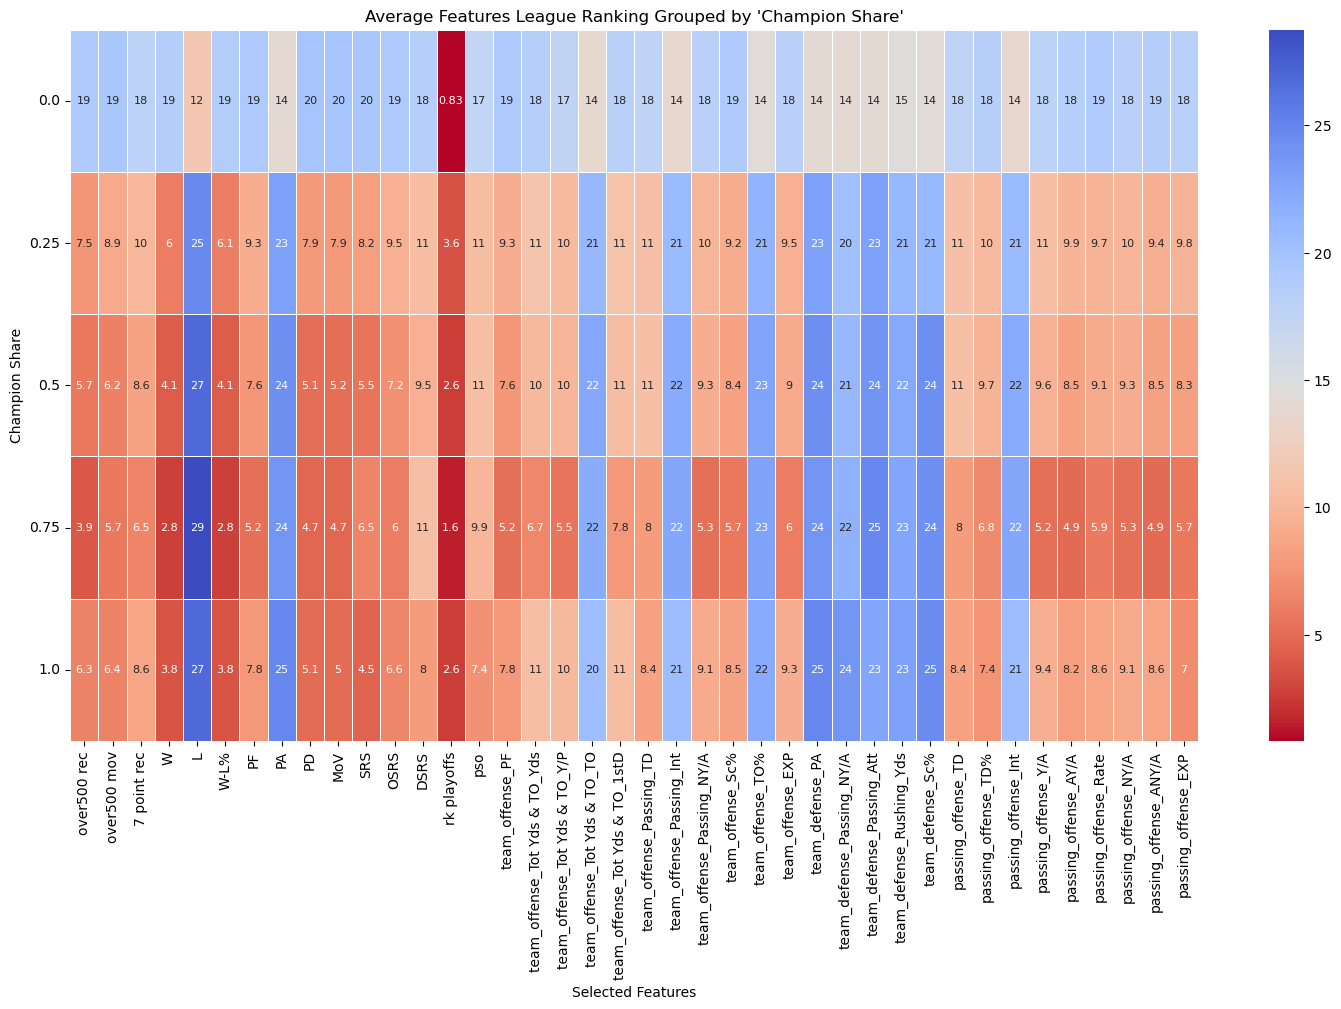

In [20]:
corr = data.corr().abs()
selected_features = corr.loc[corr['champion share'] > 0.3].index

corr_df = data[selected_features].groupby('champion share').mean()

plt.rcParams['figure.figsize'] = (15, 10)
plt.title("Average Features League Ranking Grouped by 'Champion Share'")
heatmap = sns.heatmap(data=corr_df, cmap='coolwarm_r', annot=True, linewidth=.5, annot_kws={"size": 8})

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel("Selected Features")
plt.ylabel("Champion Share")

plt.savefig("avg_fea_ht.png", bbox_inches='tight', pad_inches=0.1)

image = Image.open("avg_fea_ht.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("avg_fea_ht.png")

plt.show()

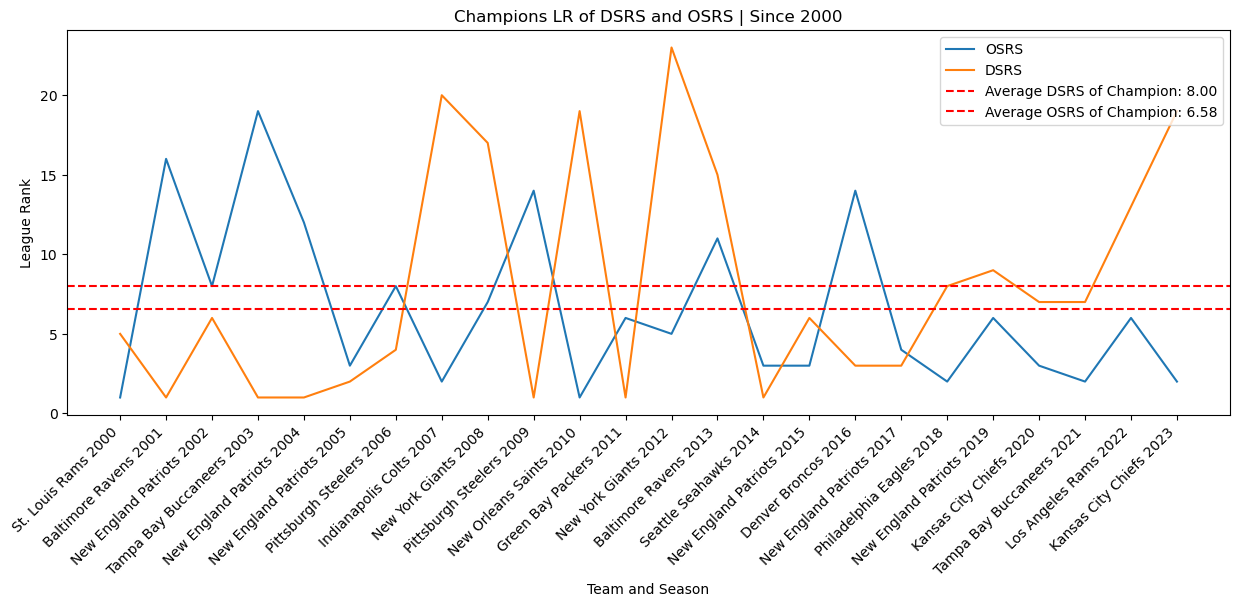

In [21]:
champion_sea = df.loc[df['champion share'] == 1].copy() 

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

plt.figure(figsize=(15, 5))
plt.title("Champions LR of DSRS and OSRS | Since 2000")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['OSRS'], label="OSRS")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['DSRS'], label="DSRS")

average_dsrs = champion_sea['DSRS'].mean()
average_osrs = champion_sea['OSRS'].mean()

plt.axhline(y=average_dsrs, color='r', linestyle='--', label=f'Average DSRS of Champion: {average_dsrs:.2f}')
plt.axhline(y=average_osrs, color='r', linestyle='--', label=f'Average OSRS of Champion: {average_osrs:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('League Rank')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.savefig("line_chart_OvD.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_OvD.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_OvD.png")

plt.show()

In [13]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['OSRS'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['OSRS'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions OSRS rank {rank}: {percentage:.2f}%")
    
#==================================================================================    
print("===========================================================================\n")

champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['DSRS'].unique()

percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['DSRS'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions DSRS rank {rank}: {percentage:.2f}%")

The percentage of champions OSRS rank Rank 2.0: 16.67%
The percentage of champions OSRS rank Rank 3.0: 16.67%
The percentage of champions OSRS rank Rank 6.0: 12.50%
The percentage of champions OSRS rank Rank 14.0: 8.33%
The percentage of champions OSRS rank Rank 1.0: 8.33%
The percentage of champions OSRS rank Rank 8.0: 8.33%
The percentage of champions OSRS rank Rank 4.0: 4.17%
The percentage of champions OSRS rank Rank 11.0: 4.17%
The percentage of champions OSRS rank Rank 5.0: 4.17%
The percentage of champions OSRS rank Rank 7.0: 4.17%
The percentage of champions OSRS rank Rank 12.0: 4.17%
The percentage of champions OSRS rank Rank 19.0: 4.17%
The percentage of champions OSRS rank Rank 16.0: 4.17%

The percentage of champions DSRS rank Rank 1.0: 25.00%
The percentage of champions DSRS rank Rank 19.0: 8.33%
The percentage of champions DSRS rank Rank 7.0: 8.33%
The percentage of champions DSRS rank Rank 3.0: 8.33%
The percentage of champions DSRS rank Rank 6.0: 8.33%
The percentage of

### What's more important offense or defense for winning NFL championship
- In terms of the average offense is more important.
- In terms of being ranked 1st in the league defense is the most important.
- Overall I think offense is slightly the more important side of the game (quarterback and scheme).

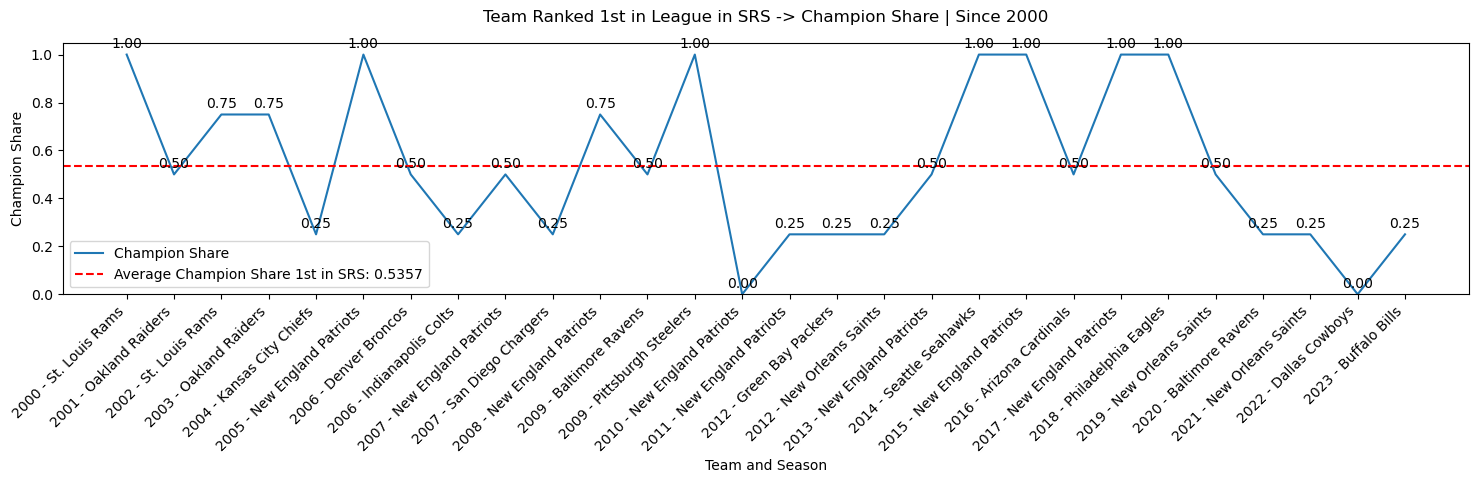

In [22]:
# Create DataFrame only selecting teams ranked 1st in the league in SRS since 2000
first_in_league_SRS = df.loc[df['SRS'] == 1].copy()
first_in_league_SRS .sort_values(by='Season', inplace=True)

plt.figure(figsize=(15, 5))
plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 2000")

plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 2000", y=1.05)

first_in_league_SRS.loc[:, 'Season'] = first_in_league_SRS['Season'].astype(str)

sns.lineplot(x=first_in_league_SRS['Season'] + " - " + first_in_league_SRS['Team'],
             y=first_in_league_SRS['champion share'],
             label="Champion Share", errorbar=None)

plt.xticks(rotation=45, ha="right")

for i, row in first_in_league_SRS.iterrows():
    plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

average_champion_share = first_in_league_SRS['champion share'].mean()
plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in SRS: {average_champion_share:.4f}')

plt.xlabel("Team and Season")
plt.ylabel("Champion Share")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()

plt.savefig("line_chart_1st_SRS.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_1st_SRS.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_1st_SRS.png")

plt.show()

In [16]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['SRS'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['SRS'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions SRS rank {rank}: {percentage:.2f}%")

The percentage of champions SRS rank Rank 1.0: 29.17%
The percentage of champions SRS rank Rank 2.0: 16.67%
The percentage of champions SRS rank Rank 6.0: 12.50%
The percentage of champions SRS rank Rank 4.0: 8.33%
The percentage of champions SRS rank Rank 8.0: 8.33%
The percentage of champions SRS rank Rank 12.0: 8.33%
The percentage of champions SRS rank Rank 11.0: 4.17%
The percentage of champions SRS rank Rank 5.0: 4.17%
The percentage of champions SRS rank Rank 7.0: 4.17%
The percentage of champions SRS rank Rank 3.0: 4.17%


### Analysis of SRS
- On average teams ranked 1st in the league in SRS, get around 2.1 playoff wins (remember 1 seeds automatically get 1 playoff win (by))
- 75% of all NFL champions ranked top 6 in the league in SRS, specifically the top 2 spots are the most important.

In [18]:
29.17+16.67+4.17+8.33+4.17+12.5

75.01

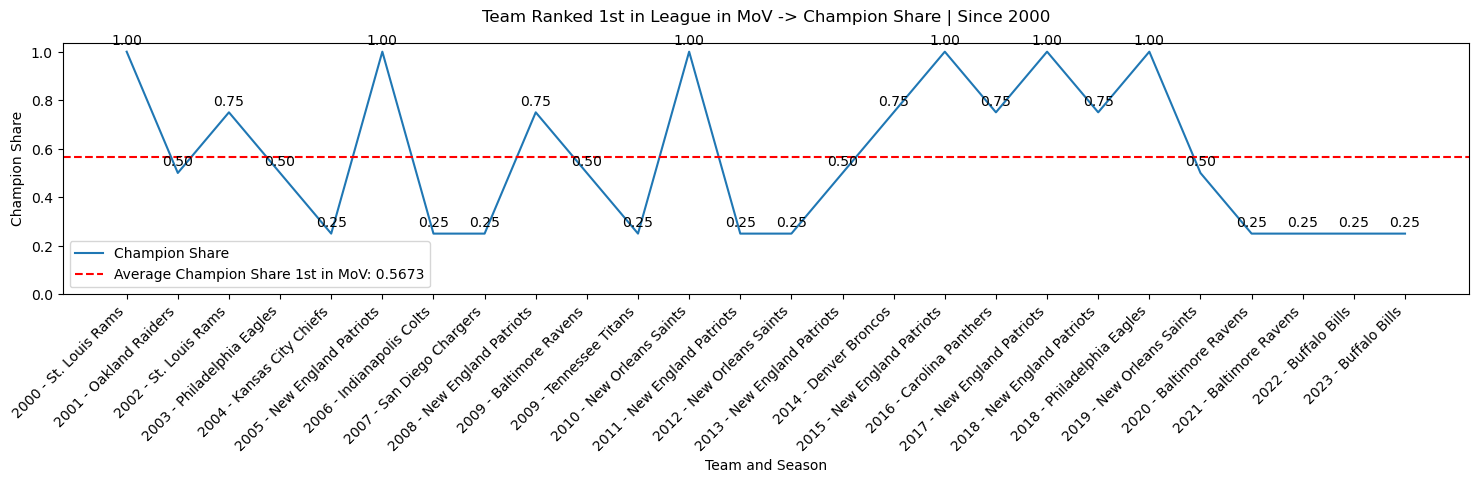

In [19]:
first_in_league_MoV = df.loc[df['MoV'] == 1].copy()

first_in_league_MoV.sort_values(by='Season', inplace=True)

plt.figure(figsize=(15, 5))
plt.title("Team Ranked 1st in League in MoV -> Champion Share | Since 2000")
plt.title("Team Ranked 1st in League in MoV -> Champion Share | Since 2000", y=1.05)

first_in_league_MoV.loc[:, 'Season'] = first_in_league_MoV['Season'].astype(str)

sns.lineplot(x=first_in_league_MoV['Season'] + " - " + first_in_league_MoV['Team'],
             y=first_in_league_MoV['champion share'],
             label="Champion Share", errorbar=None)

plt.xticks(rotation=45, ha="right")

for i, row in first_in_league_MoV.iterrows():
    plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

average_champion_share = first_in_league_MoV['champion share'].mean()
plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in MoV: {average_champion_share:.4f}')

plt.xlabel("Team and Season")
plt.ylabel("Champion Share")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['MoV'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['MoV'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions MoV rank {rank}: {percentage:.2f}%")

The percentage of champions MoV rank Rank 1.0: 25.00%
The percentage of champions MoV rank Rank 4.0: 16.67%
The percentage of champions MoV rank Rank 2.0: 16.67%
The percentage of champions MoV rank Rank 5.0: 12.50%
The percentage of champions MoV rank Rank 6.0: 4.17%
The percentage of champions MoV rank Rank 10.0: 4.17%
The percentage of champions MoV rank Rank 11.0: 4.17%
The percentage of champions MoV rank Rank 19.0: 4.17%
The percentage of champions MoV rank Rank 13.0: 4.17%
The percentage of champions MoV rank Rank 9.0: 4.17%
The percentage of champions MoV rank Rank 7.0: 4.17%


### Analysis of MoV
- On average teams ranked 1st in the league in MoV, get around 2.3 playoff wins (remember 1 seeds automatically get 1 playoff win (by))
- 75% of all NFL champions ranked top 6 in the league in MoV, specifically the top is the most important.

In [22]:
25+16.67+16.67+12.5+4.17

75.01

In [24]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

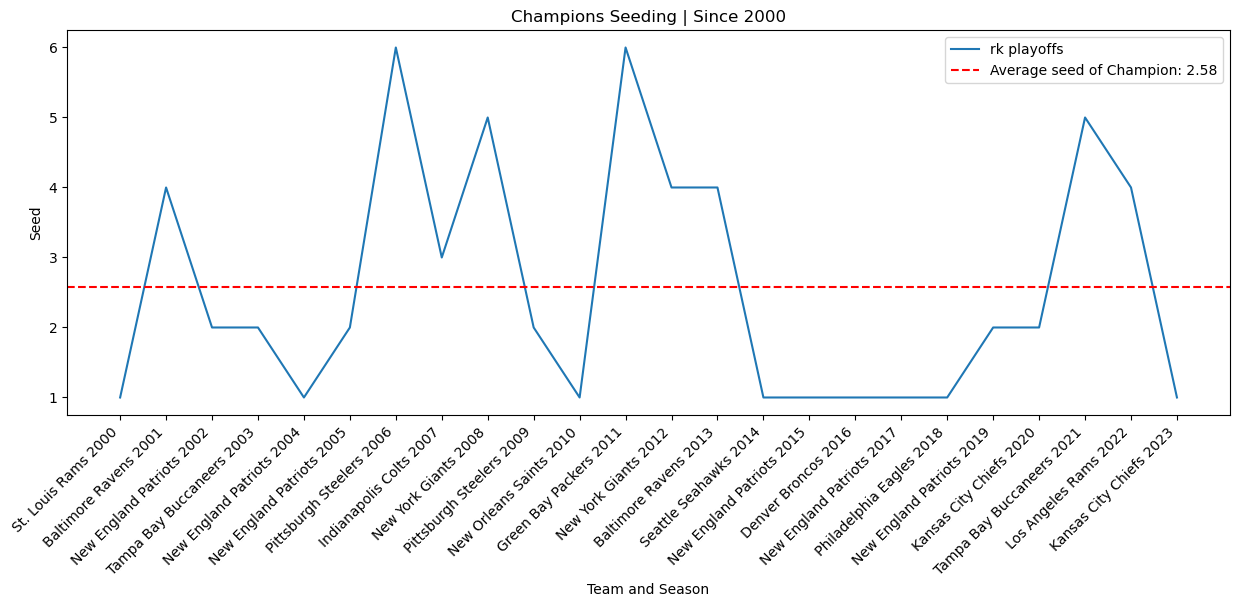

In [23]:
champion_sea = df.loc[df['champion share'] == 1].copy() 

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

plt.figure(figsize=(15, 5))
plt.title("Champions Seeding | Since 2000")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['rk playoffs'], label="rk playoffs")

average_dsrs = champion_sea['rk playoffs'].mean()

plt.axhline(y=average_dsrs, color='r', linestyle='--', label=f'Average seed of Champion: {average_dsrs:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('Seed')

plt.xticks(rotation=45, ha='right')
plt.legend()

plt.savefig("line_chart_seeding.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_seeding.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_seeding.png")

plt.show()

In [30]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['rk playoffs'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['rk playoffs'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions seed {rank}: {percentage:.2f}%")

The percentage of champions seed Rank 1: 37.50%
The percentage of champions seed Rank 2: 25.00%
The percentage of champions seed Rank 4: 16.67%
The percentage of champions seed Rank 5: 8.33%
The percentage of champions seed Rank 6: 8.33%
The percentage of champions seed Rank 3: 4.17%


### Analysis of Champion Seeding
- 14/23 NFL Champions are top 2 seeds
- on average the NFL champion must be a top 2 seed.
- The 3 seed is a disadvantage, lowest champion occuerence seed.
- The 4 seed is a sweet spot.

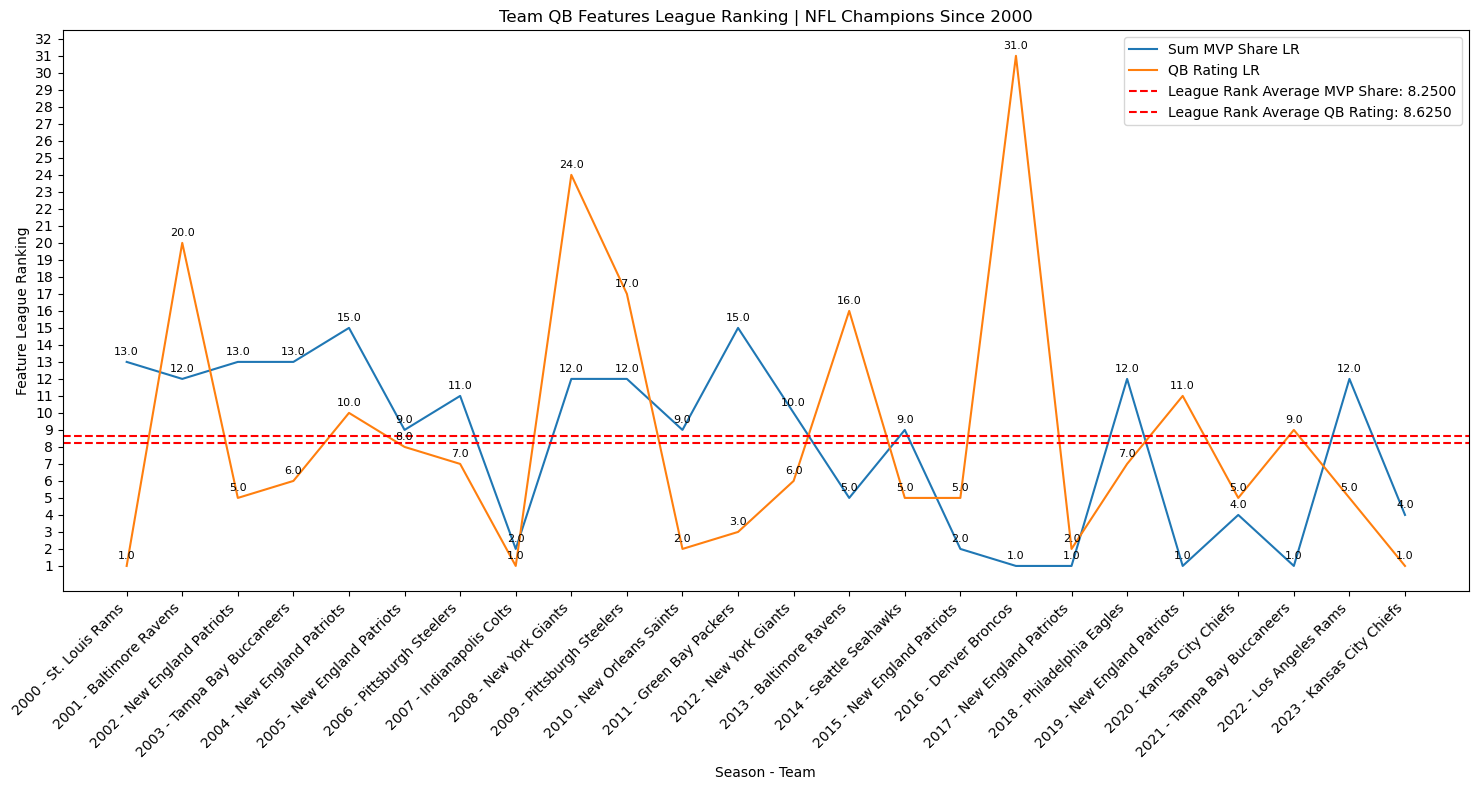

In [24]:
champion = df.loc[df['champion share'] == 1.00].copy()

champion.sort_values(by='Season', inplace=True)

plt.figure(figsize=(15, 8))

champion.loc[:, 'Season_Team'] = champion['Season'].astype(str) + " - " + champion['Team']

sns.lineplot(x=champion['Season_Team'], y=champion['sum mvp share'], label="Sum MVP Share LR", errorbar=None)
sns.lineplot(x=champion['Season_Team'], y=champion['passing_offense_Rate'], label="QB Rating LR", errorbar=None)

plt.xticks(rotation=45, ha="right")
plt.yticks(range(1, 33))

average_mvp_ranking = champion['sum mvp share'].mean()
plt.axhline(y=average_mvp_ranking, color='r', linestyle='--', label=f'League Rank Average MVP Share: {average_mvp_ranking:.4f}')

average_mvp_ranking = champion['passing_offense_Rate'].mean()
plt.axhline(y=average_mvp_ranking, color='r', linestyle='--', label=f'League Rank Average QB Rating: {average_mvp_ranking:.4f}')

for season_team, rank in zip(champion['Season_Team'], champion['sum mvp share']):
    plt.annotate(f'{rank}', (season_team, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
    
for season_team, rank in zip(champion['Season_Team'], champion['passing_offense_Rate']):
    plt.annotate(f'{rank}', (season_team, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("Team QB Features League Ranking | NFL Champions Since 2000")
plt.xlabel("Season - Team")
plt.ylabel("Feature League Ranking")
plt.legend()
plt.tight_layout()

plt.savefig("line_chart_qb.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_qb.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_qb.png")

plt.show()

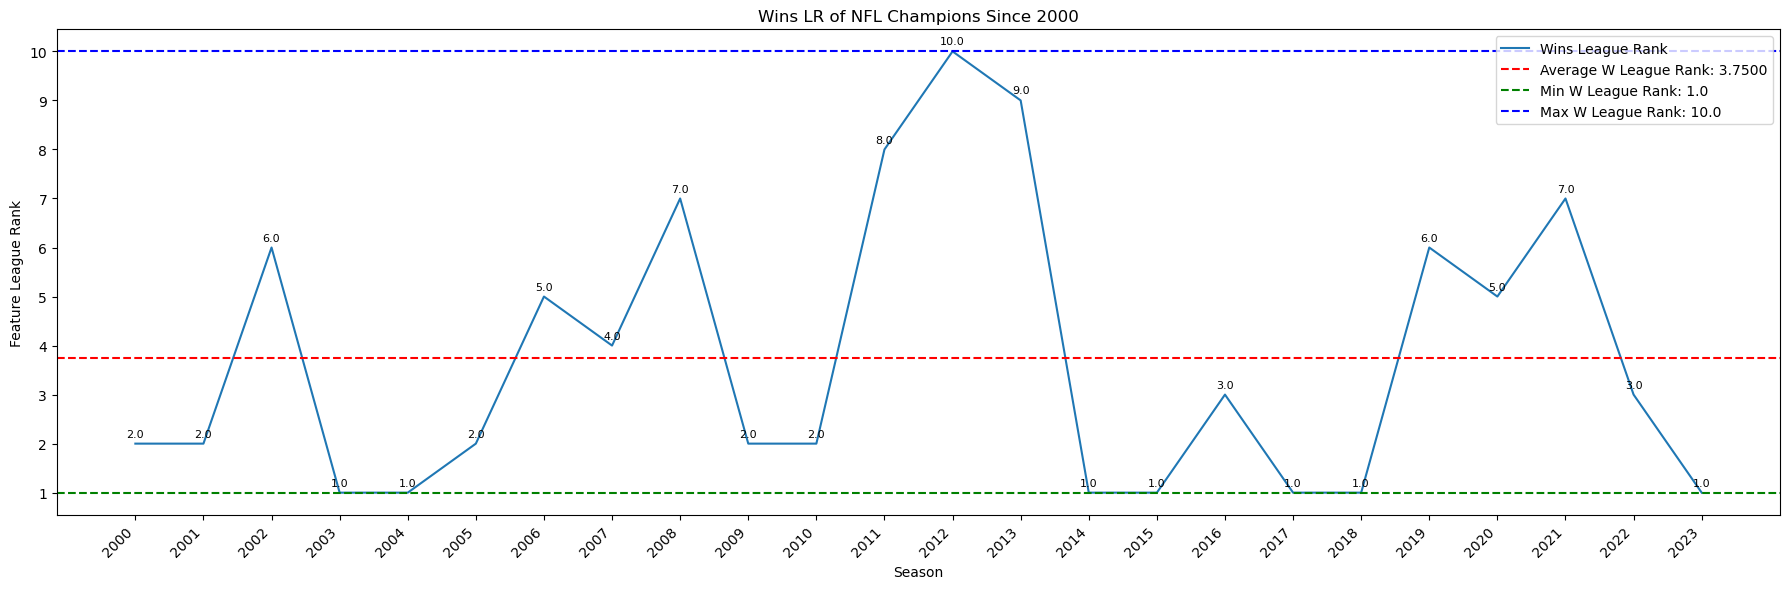

In [25]:
champion = df.loc[df['champion share'] == 1.00]

plt.figure(figsize=(18, 6))

sns.lineplot(x=champion['Season'], y=champion['W'], label="Wins League Rank", err_style="band")

plt.xticks(champion['Season'].unique(), rotation=45, ha="right")

plt.yticks(range(1, 11))

average_champion_wins_ranking = champion['W'].mean()
min_champion_wins_ranking = champion['W'].min()
max_champion_wins_ranking = champion['W'].max()

plt.axhline(y=average_champion_wins_ranking, color='r', linestyle='--', label=f'Average W League Rank: {average_champion_wins_ranking:.4f}')
plt.axhline(y=min_champion_wins_ranking, color='g', linestyle='--', label=f'Min W League Rank: {min_champion_wins_ranking}')
plt.axhline(y=max_champion_wins_ranking, color='b', linestyle='--', label=f'Max W League Rank: {max_champion_wins_ranking}')

for season, rank in zip(champion['Season'], champion['W']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("Wins LR of NFL Champions Since 2000")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()
plt.tight_layout()

plt.savefig("line_chart_wins.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_wins.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_wins.png")

plt.show()

In [41]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['W'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['W'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions Wins {rank}: {percentage:.2f}%")

The percentage of champions Wins Rank 1.0: 29.17%
The percentage of champions Wins Rank 2.0: 20.83%
The percentage of champions Wins Rank 3.0: 8.33%
The percentage of champions Wins Rank 7.0: 8.33%
The percentage of champions Wins Rank 5.0: 8.33%
The percentage of champions Wins Rank 6.0: 8.33%
The percentage of champions Wins Rank 9.0: 4.17%
The percentage of champions Wins Rank 10.0: 4.17%
The percentage of champions Wins Rank 8.0: 4.17%
The percentage of champions Wins Rank 4.0: 4.17%


### Analysis of Champion Wins LR
- 16/23 NFL Champions are top 5 teams in the league in Wins

In [44]:
#Champions | Summary Stats 
champion = df.loc[df['champion share'] == 1.00]
champion_wins_rank_summary = champion['W'].describe()

print("Summary Statistics for Champions' League Rank of Wins:")
print(champion_wins_rank_summary)

champion = df.loc[df['champion share'] == 1.00]
champion_srs_rank_summary = champion['SRS'].describe()

print("Summary Statistics for Champions' League Rank of SRS:")
print(champion_srs_rank_summary)

Summary Statistics for Champions' League Rank of Wins:
count    24.000000
mean      3.750000
std       2.862805
min       1.000000
25%       1.000000
50%       2.500000
75%       6.000000
max      10.000000
Name: W, dtype: float64
Summary Statistics for Champions' League Rank of SRS:
count    24.000000
mean      4.458333
std       3.647264
min       1.000000
25%       1.000000
50%       3.500000
75%       6.250000
max      12.000000
Name: SRS, dtype: float64


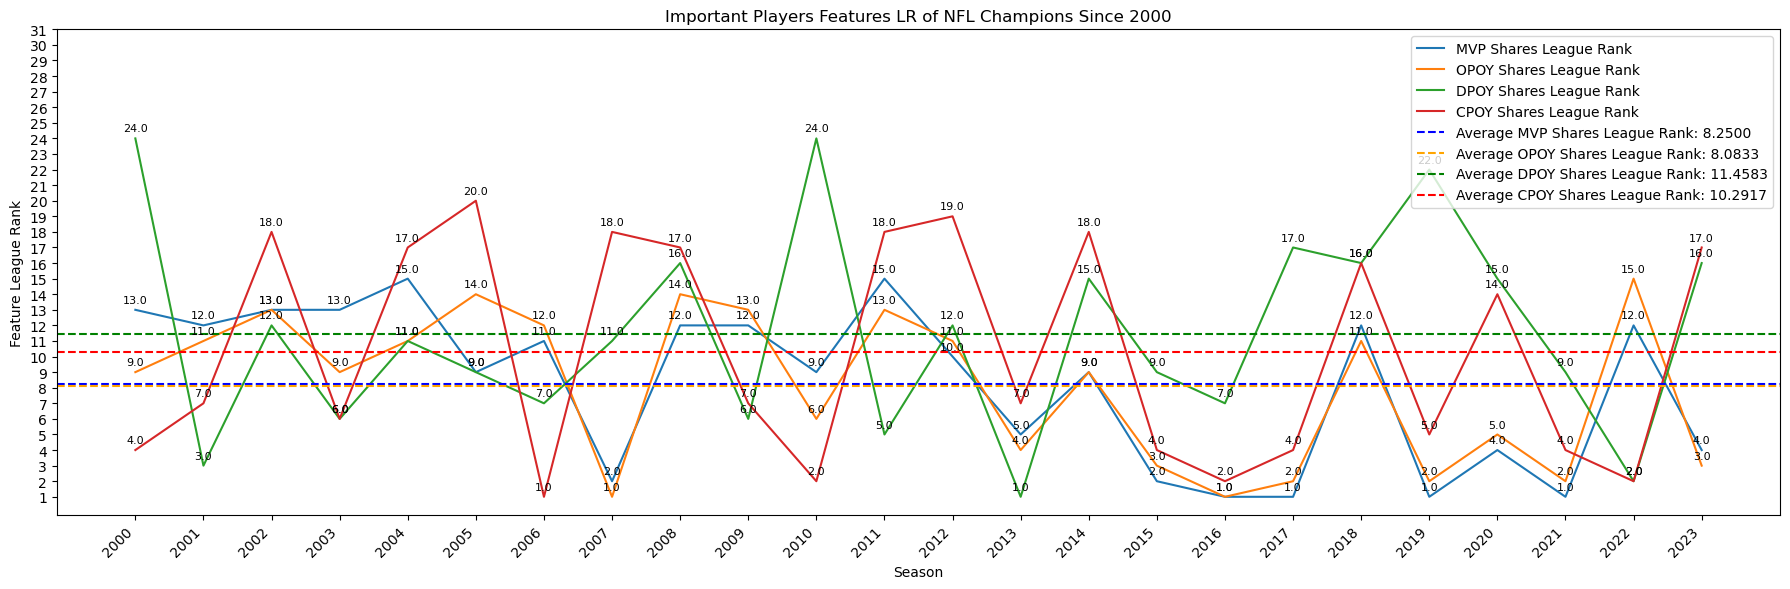

In [45]:
champion = df.loc[df['champion share'] == 1.00]
plt.figure(figsize=(18, 6))

sns.lineplot(x=champion['Season'], y=champion['sum mvp share'], label="MVP Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum opoy share'], label="OPOY Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum dpoy share'], label="DPOY Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum cpoy share'], label="CPOY Shares League Rank", err_style="band")

plt.xticks(champion['Season'].unique(), rotation=45, ha="right")
plt.yticks(range(1, 32))

average_champion_ms_ranking = champion['sum mvp share'].mean()
average_champion_os_ranking = champion['sum opoy share'].mean()
average_champion_ds_ranking = champion['sum dpoy share'].mean()
average_champion_cs_ranking = champion['sum cpoy share'].mean()

plt.axhline(y=average_champion_ms_ranking, color='blue', linestyle='--', label=f'Average MVP Shares League Rank: {average_champion_ms_ranking:.4f}')
plt.axhline(y=average_champion_os_ranking, color='orange', linestyle='--', label=f'Average OPOY Shares League Rank: {average_champion_os_ranking:.4f}')
plt.axhline(y=average_champion_ds_ranking, color='green', linestyle='--', label=f'Average DPOY Shares League Rank: {average_champion_ds_ranking:.4f}')
plt.axhline(y=average_champion_cs_ranking, color='red', linestyle='--', label=f'Average CPOY Shares League Rank: {average_champion_cs_ranking:.4f}')

for season, rank in zip(champion['Season'], champion['sum mvp share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum opoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum dpoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum cpoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("Important Players Features LR of NFL Champions Since 2000")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

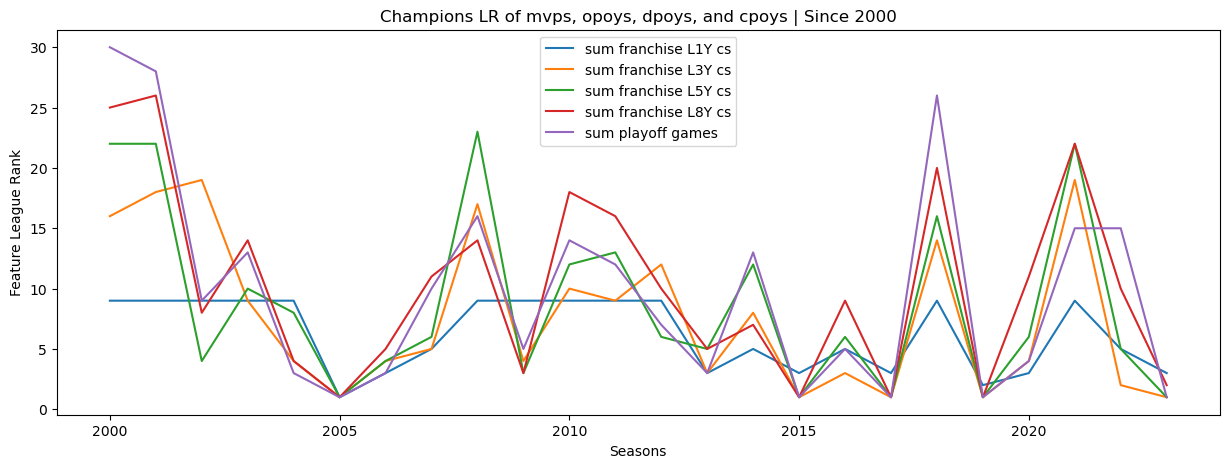

In [47]:
champion_sea = df.loc[df['champion share']==1]

plt.figure(figsize=(15,5))
plt.title("Champions LR of mvps, opoys, dpoys, and cpoys | Since 2000")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L1Y cs'],label="sum franchise L1Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L3Y cs'],label="sum franchise L3Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L5Y cs'],label="sum franchise L5Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L8Y cs'],label="sum franchise L8Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum playoff games'],label="sum playoff games")
plt.xlabel('Seasons')
plt.ylabel('Feature League Rank')
plt.show()

Pearson Correlation Coefficient: 0.7217


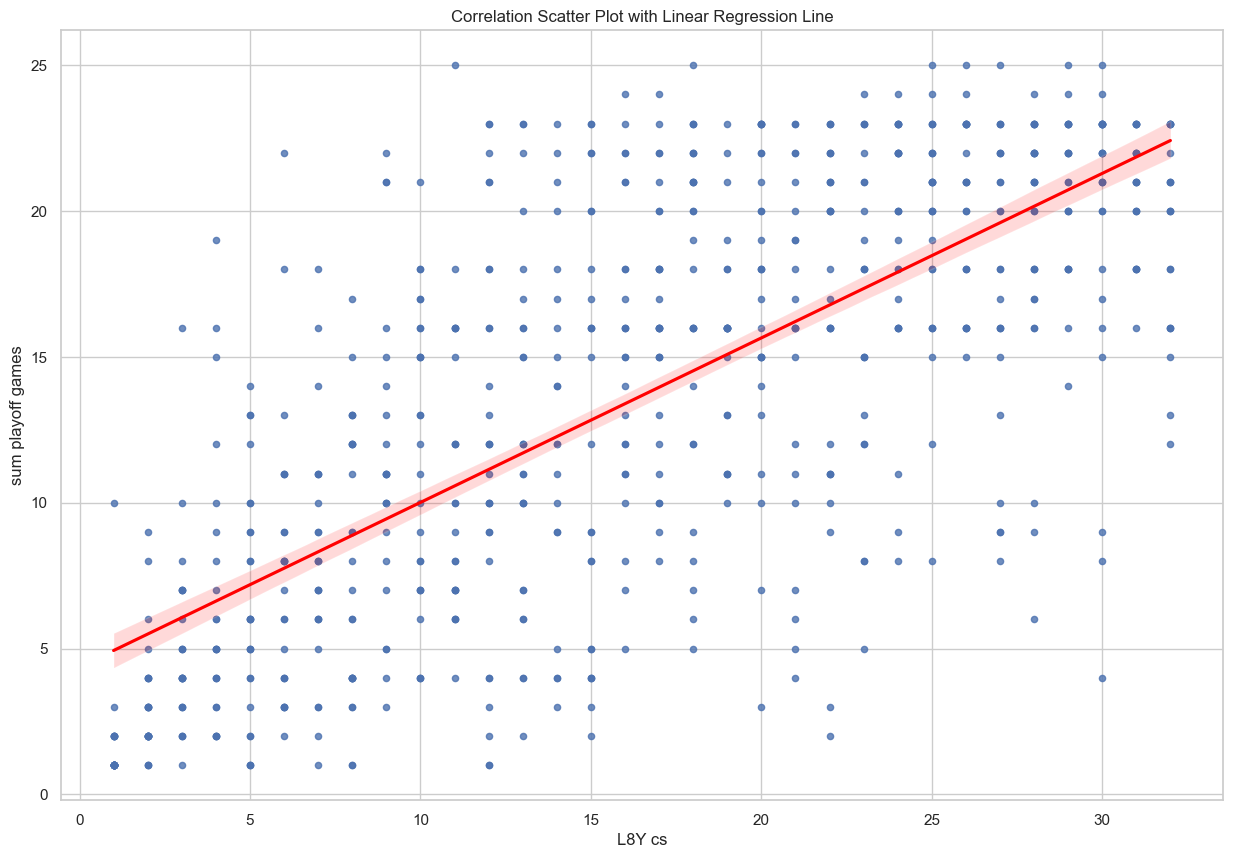

In [49]:
from scipy.stats import pearsonr
sns.set(style="whitegrid") 
sns.regplot(x=data['sum playoff games'], y=data['sum franchise L5Y cs'], scatter_kws={"s": 20}, line_kws={"color": "red"})

plt.xlabel("L8Y cs")
plt.ylabel("sum playoff games")
plt.title("Correlation Scatter Plot with Linear Regression Line")

correlation_coefficient, _ = pearsonr(data['sum playoff games'], data['sum franchise L5Y cs'])
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")

plt.show()

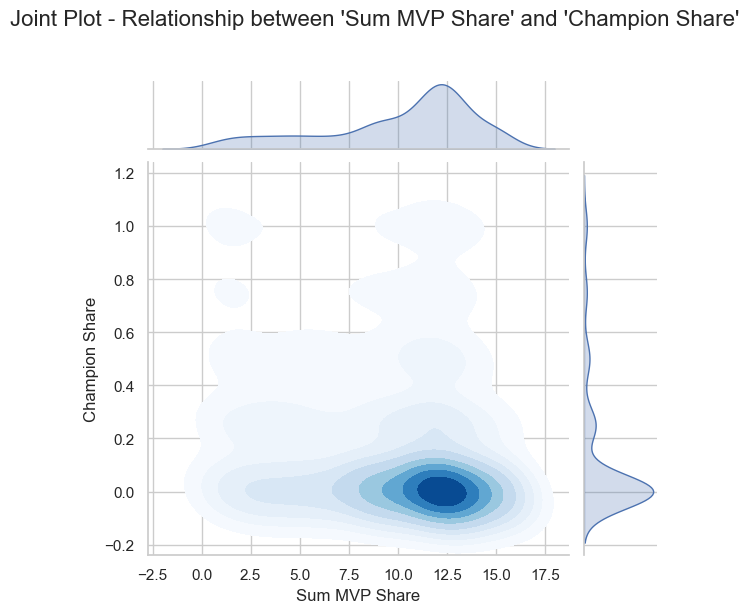

In [50]:
joint_plot = sns.jointplot(x=data['sum mvp share'], y=data['champion share'], kind='kde', fill=True, cmap='Blues')
joint_plot.set_axis_labels("Sum MVP Share", "Champion Share", fontsize=12)
joint_plot.fig.suptitle("Joint Plot - Relationship between 'Sum MVP Share' and 'Champion Share'", y=1.02, fontsize=16)
joint_plot.fig.subplots_adjust(top=0.9)
plt.show()

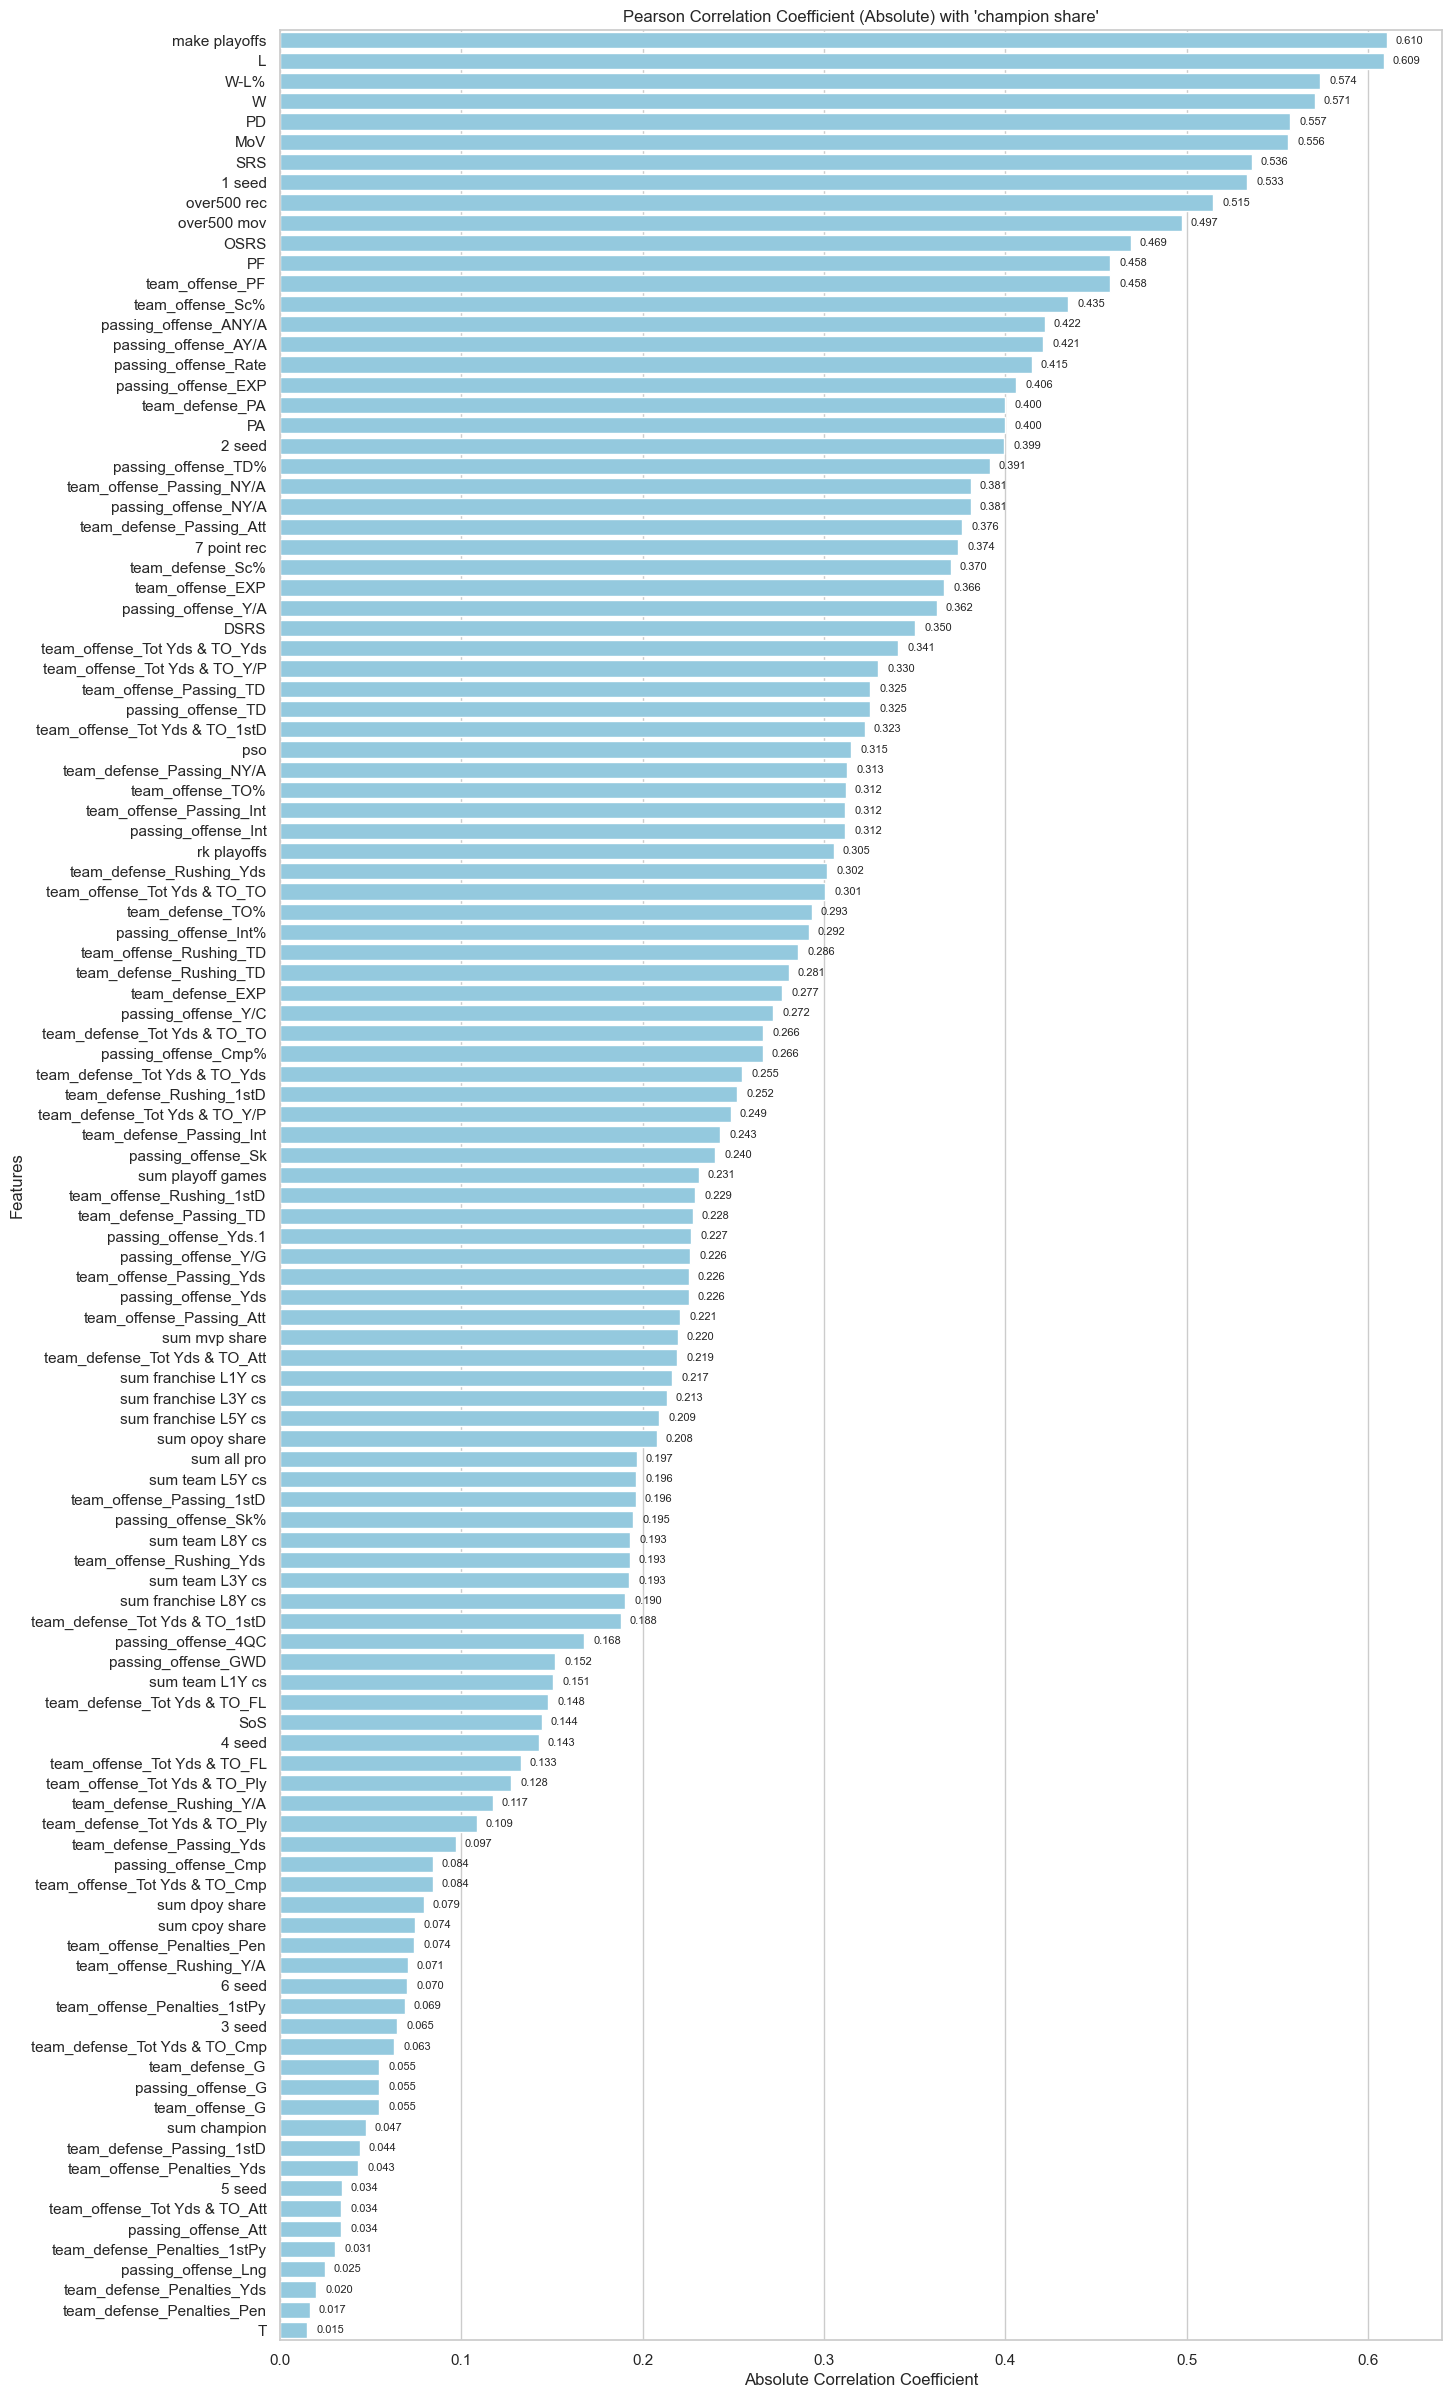

In [51]:
data_columns = ['over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_G', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Yds.1', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']

selected_data = df[data_columns]

correlation_matrix = selected_data.corr()

correlation_with_champion = correlation_matrix['champion share'].drop('champion share')
sorted_correlation = correlation_with_champion.abs().sort_values(ascending=False)

plt.figure(figsize=(15, 30))
ax = sns.barplot(x=sorted_correlation.values, y=sorted_correlation.index, color='skyblue')

for i, value in enumerate(sorted_correlation):
    ax.text(value + 0.005, i, f'{value:.3f}', va='center', fontsize=8)

plt.title("Pearson Correlation Coefficient (Absolute) with 'champion share'")
plt.xlabel("Absolute Correlation Coefficient")
plt.ylabel("Features")
plt.show()

Column Averages:
SRS                               4.458333
rk playoffs                       2.583333
team_defense_Passing_Att         22.625000
team_offense_Passing_Yds         10.833333
team_defense_Tot Yds & TO_Ply    16.666667
passing_offense_EXP               6.958333
pso                               7.375000
sum franchise L3Y cs              7.708333
team_defense_Sc%                 24.541667
team_defense_Rushing_Y/A         19.750000
passing_offense_GWD              10.458333
passing_offense_Lng              15.208333
OSRS                              6.583333
sum mvp share                     8.250000
sum team L3Y cs                  10.916667
passing_offense_Y/C              10.291667
DSRS                              8.000000
dtype: float64


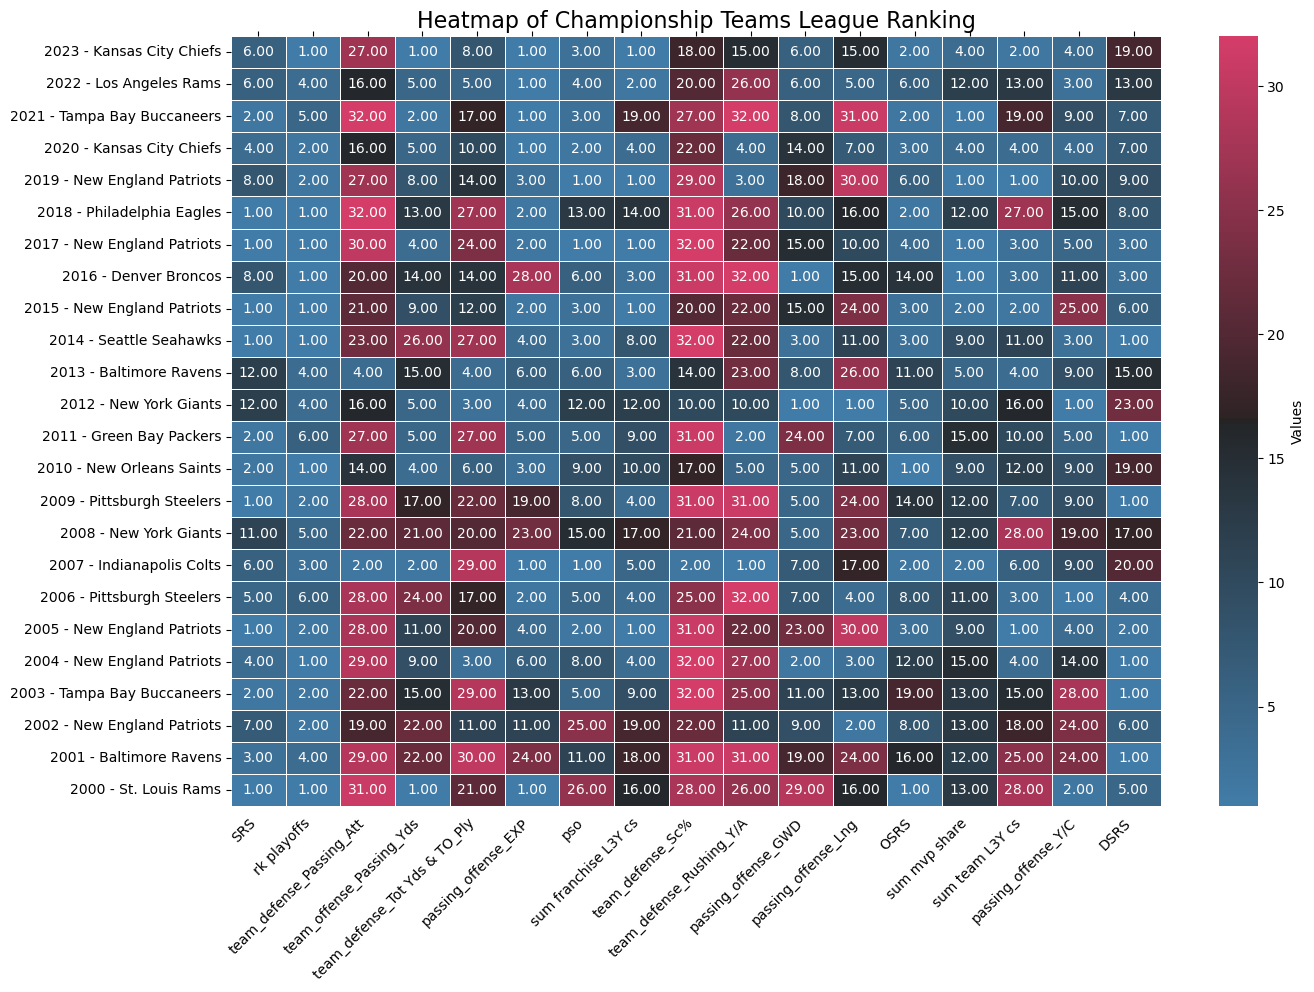

In [29]:
custom_palette = sns.diverging_palette(240, 0, s=75, l=50, n=10, center="dark", as_cmap=True)

champions_only = df.loc[df['champion share'] == 1, ['Season', 'Team', 'SRS', 'rk playoffs', 'team_defense_Passing_Att', 'team_offense_Passing_Yds', 'team_defense_Tot Yds & TO_Ply', 'passing_offense_EXP', 'pso',
                                                   'sum franchise L3Y cs','team_defense_Sc%', 'team_defense_Rushing_Y/A', 'passing_offense_GWD', 'passing_offense_Lng' ,'OSRS', 'sum mvp share', 'sum team L3Y cs', 'passing_offense_Y/C' ,'DSRS']]

heatmap_data = champions_only[['SRS', 'rk playoffs', 'team_defense_Passing_Att', 'team_offense_Passing_Yds', 'team_defense_Tot Yds & TO_Ply', 'passing_offense_EXP', 'pso',
                                                   'sum franchise L3Y cs','team_defense_Sc%', 'team_defense_Rushing_Y/A', 'passing_offense_GWD', 'passing_offense_Lng' ,'OSRS', 'sum mvp share', 'sum team L3Y cs', 'passing_offense_Y/C' ,'DSRS']]

plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=custom_palette, linewidths=.5, cbar_kws={'label': 'Values'})

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_headers = heatmap_data.columns.tolist()
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

plt.tick_params(axis='x', which='both', bottom=False, top=True)

column_averages = heatmap_data.mean()
print("Column Averages:")
print(column_averages)

plt.title('Heatmap of Championship Teams League Ranking', fontsize=16)

plt.savefig("ht_allChamps_fea_table.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_allChamps_fea_table.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_allChamps_fea_table.png")

plt.show()

In [54]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

## Analyzing Champions outside of the top 6 in SRS

Column Averages:
over500 rec                      7.833333
over500 mov                     10.833333
7 point rec                      6.500000
sum mvp share                    7.000000
sum dpoy share                  11.666667
sum opoy share                   7.500000
sum all pro                      9.500000
sum cpoy share                  11.333333
sum playoff games                6.833333
sum champion                    17.166667
sum team L1Y cs                 10.500000
sum team L3Y cs                 11.666667
sum team L5Y cs                  9.666667
sum team L8Y cs                  9.333333
sum franchise L1Y cs             6.166667
sum franchise L3Y cs             9.166667
sum franchise L5Y cs             7.500000
sum franchise L8Y cs             7.833333
W-L%                             6.833333
PF                              10.333333
PA                              20.833333
PD                              10.833333
MoV                             10.833333
SoS              

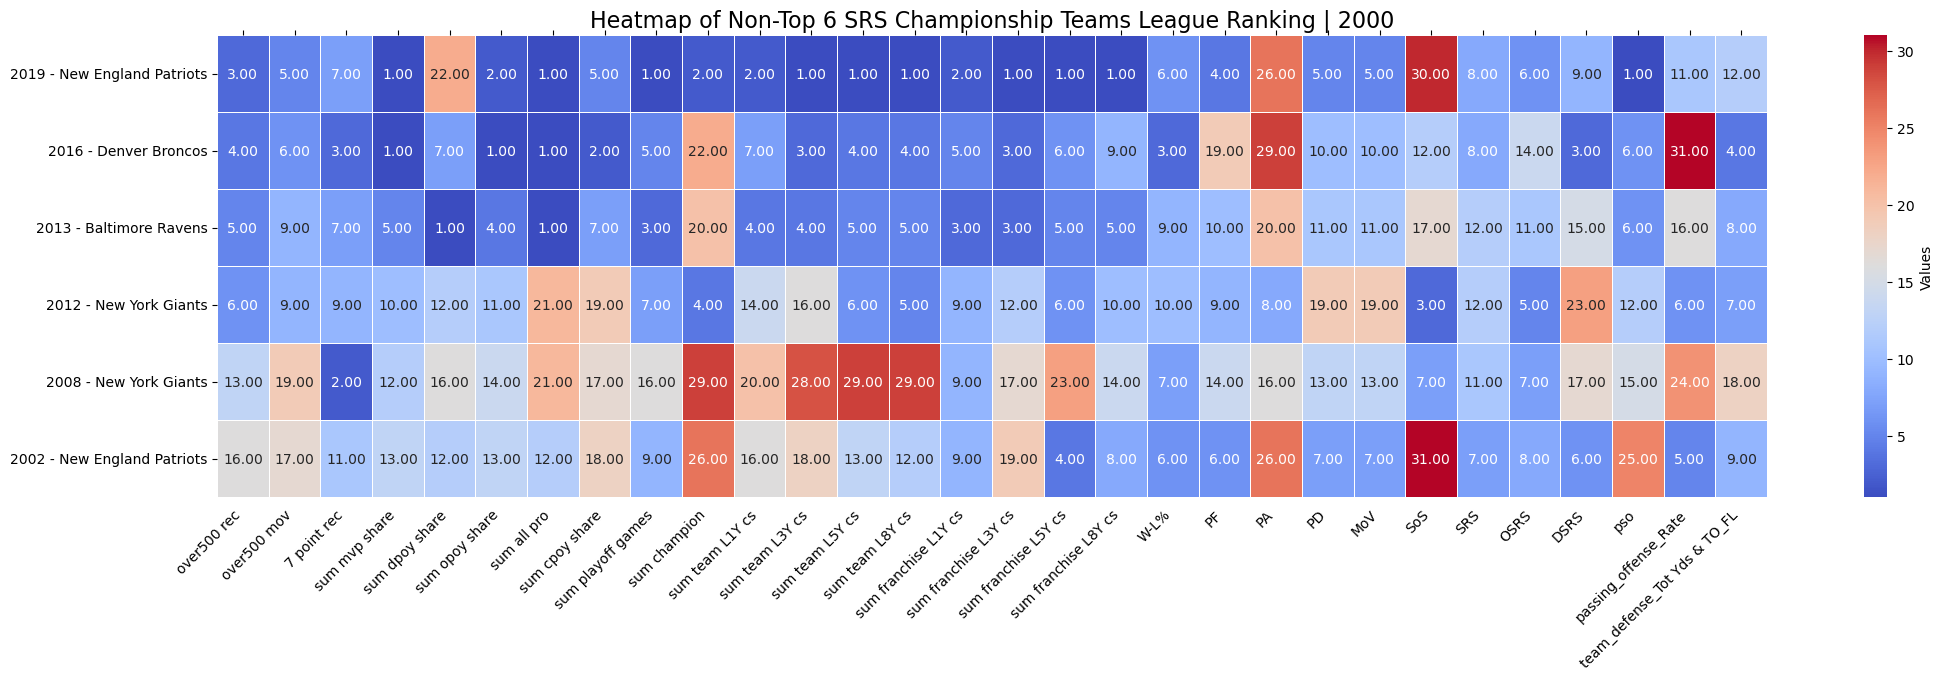

In [9]:
df = pd.read_csv("NFL Champion LR Data.csv")
#df = pd.read_csv("NFL Champion RawData.csv")

teams_of_interest = ['New England Patriots 2018', 'Denver Broncos 2015', 'Baltimore Ravens 2012', 'New York Giants 2011', 'New York Giants 2007','New England Patriots 2001']
champions_only = df[df['Team/Season'].isin(teams_of_interest)].copy()  

numeric_columns = ['over500 rec', 'over500 mov', '7 point rec', 
                   'sum mvp share', 'sum dpoy share', 'sum opoy share',
                   'sum all pro', 'sum cpoy share', 'sum playoff games',
                   'sum champion', 'sum team L1Y cs', 'sum team L3Y cs',
                   'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 
                   'sum franchise L5Y cs', 'sum franchise L8Y cs','W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS','pso','passing_offense_Rate','team_defense_Tot Yds & TO_FL']

champions_only.loc[:, numeric_columns] = champions_only.loc[:, numeric_columns].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(25, 6))
heatmap = sns.heatmap(champions_only[numeric_columns], annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar_kws={'label': 'Values'})

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_headers = numeric_columns
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

plt.tick_params(axis='x', which='both', bottom=False, top=True)

column_averages = champions_only[numeric_columns].mean()
print("Column Averages:")
print(column_averages)

plt.title('Heatmap of Non-Top 6 SRS Championship Teams League Ranking | 2000', fontsize=16)
plt.savefig("ht_champs_nt6_srs.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_champs_nt6_srs.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_champs_nt6_srs.png")
plt.show()

Column Averages:
over500 rec                0.517659
over500 mov               -0.614583
7 point rec                0.663294
sum mvp share              1.343167
sum dpoy share             0.533000
sum opoy share             0.749833
sum all pro               18.166667
sum cpoy share             0.216333
sum playoff games        197.000000
sum champion               7.500000
sum team L1Y cs            6.416667
sum team L3Y cs           16.666667
sum team L5Y cs           24.500000
sum team L8Y cs           28.041667
sum franchise L1Y cs       0.250000
sum franchise L3Y cs       0.791667
sum franchise L5Y cs       1.500000
sum franchise L8Y cs       1.916667
W-L%                       0.656250
PF                       387.833333
PA                       331.333333
PD                        56.500000
MoV                        3.533333
SoS                        0.300000
SRS                        3.850000
OSRS                       2.066667
DSRS                       1.766667
pso        

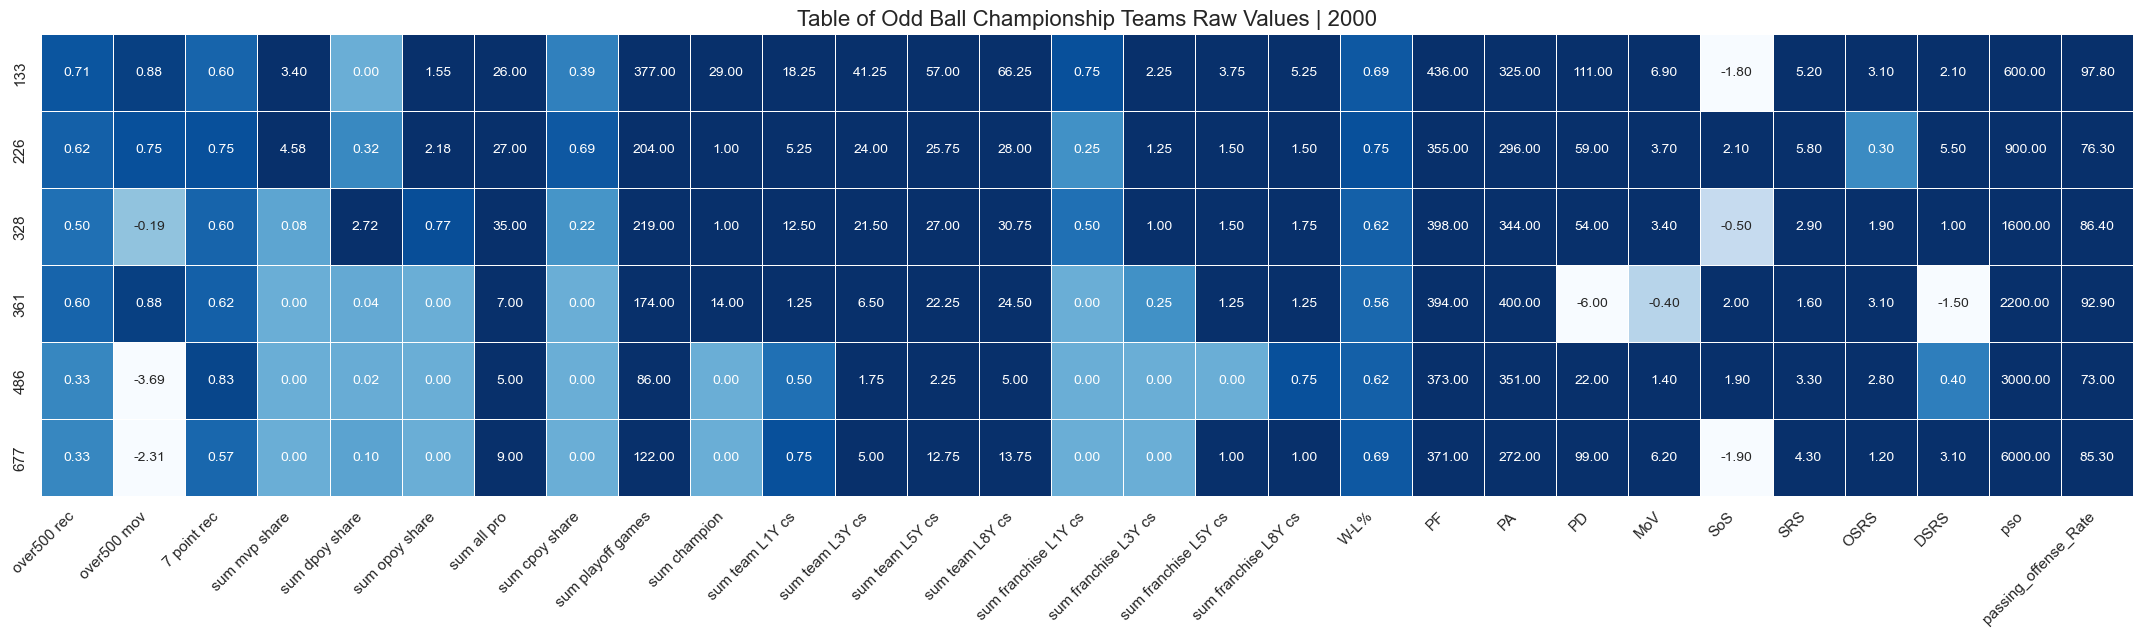

In [70]:
df = pd.read_excel("NFL Champion RawData.xlsx")

teams_of_interest = ['New England Patriots 2018', 'Denver Broncos 2015', 'Baltimore Ravens 2012', 'New York Giants 2011', 'New York Giants 2007','New England Patriots 2001']
champions_only = df[df['Team/Season'].isin(teams_of_interest)].copy()  

numeric_columns = ['over500 rec', 'over500 mov', '7 point rec', 
                   'sum mvp share', 'sum dpoy share', 'sum opoy share',
                   'sum all pro', 'sum cpoy share', 'sum playoff games',
                   'sum champion', 'sum team L1Y cs', 'sum team L3Y cs',
                   'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 
                   'sum franchise L5Y cs', 'sum franchise L8Y cs','W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS','pso','passing_offense_Rate']

champions_only.loc[:, numeric_columns] = champions_only.loc[:, numeric_columns].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(27, 6))

sns.heatmap(champions_only[numeric_columns], annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Blues', annot_kws={'size': 10}, vmin=-1, vmax=1)

column_headers = numeric_columns
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

column_averages = champions_only[numeric_columns].mean()
print("Column Averages:")
print(column_averages)

plt.title('Table of Non-Top 6 SRS Championship Teams Raw Values | 2000', fontsize=16)
plt.show()

### How did these These teams do it?
- Overall it's very to hard decipher these teams title runs, not entirely similiar to each other.
- The all had over 5 all pro selections.
- Over 62% win loss record
- The either has some sum dpoy shares or sum mvp shares